# Parameters

In [1]:
appid=''
disk=''
nic=''
tz=''
base_dir=''
name=''
proxy=''

comp_appid=''
comp_base_dir=''
comp_name=''

In [2]:
# Parameters
appid = "application_1733153225851_0048"
disk = "nvme0n1"
nic = "enp61s0f0"
tz = "Etc/GMT+0"
base_dir = "sr213"
name = "tpch_gluten"
comp_appid = "application_1733153225851_0029"
comp_base_dir = "sr213"
comp_name = "vanilla"
proxy = "http://10.239.44.250:8080"


# start analysis cluster and run

In [3]:
import findspark
findspark.init()

In [4]:
import os
def get_py4jzip():
    spark_home=os.environ['SPARK_HOME']
    py4jzip = !ls {spark_home}/python/lib/py4j*.zip
    return py4jzip[0]

In [5]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
import time
import sys
conf = (SparkConf()
    .set('spark.app.name', f'perf_analysis_{appid}')
    .set('spark.serializer','org.apache.spark.serializer.KryoSerializer')
    .set('spark.executor.instances', '4')
    .set('spark.executor.cores','4')
    .set('spark.executor.memory', '8g')
    .set('spark.driver.memory','20g')
    .set('spark.memory.offHeap.enabled','True')
    .set('spark.memory.offHeap.size','20g')
    .set('spark.executor.memoryOverhead','1g')
    .set('spark.executor.extraJavaOptions',
          '-XX:+UseParallelGC -XX:+UseParallelOldGC -verbose:gc -XX:+PrintGCDetails -XX:+PrintGCTimeStamps')
    .set('spark.executorEnv.PYTHONPATH',f"{os.environ['SPARK_HOME']}/python:{get_py4jzip()}:{':'.join(sys.path)}")
    .set('spark.sql.inMemoryColumnarStorage.compressed','False')
    .set('spark.sql.inMemoryColumnarStorage.batchSize','100000')
    .set('spark.sql.execution.arrow.pyspark.fallback.enabled','True')
    .set('spark.sql.execution.arrow.pyspark.enabled','True')
    .set('spark.sql.execution.arrow.maxRecordsPerBatch','100000')
    .set("spark.sql.repl.eagerEval.enabled", True)
    .set("spark.sql.legacy.timeParserPolicy","LEGACY")     
    .set("spark.sql.session.timeZone", tz)
       )

sc = SparkContext(conf=conf,master='yarn')
sc.setLogLevel("ERROR")
spark = SQLContext(sc)
time.sleep(10)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/12/06 05:53:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


24/12/06 05:53:37 WARN DomainSocketFactory: The short-circuit local reads feature cannot be used because libhadoop cannot be loaded.
24/12/06 05:53:37 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


/home/sparkuser/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [6]:
%%html
<style>
div.output_stderr {
background: #ffdd;
display: none;
}
</style>

# Sparklog

In [7]:
%run ~/PAUS/sparklog.ipynb

In [8]:
os.environ["https_proxy"] = proxy
os.environ["http_proxy"] = proxy

In [9]:
emonmetric=['emon_cpuutil',
            'emon_cpufreq',
            'emon_instr_retired',
            'emon_ipc']

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
disk_prefix=[f"'{dev}'" for dev in disk.split(',')]
nic_prefix=[f"'{dev}'" for dev in nic.split(',')]

# Content

In [12]:
display(HTML('<a href=#Self-app-info> 5 Self app info</a>'))
display(HTML(f"<a href=#Compare-to{'-' + comp_name if comp_name else ''}> 6 Compare to {comp_name}</a>"))
display(HTML('<a href=#Config-compare> 7 Config compare</a>'))

# Self app info

In [13]:
app=Application_Run(appid, basedir=base_dir)
appals=app.analysis['app']['als']

In [14]:
appals.get_basic_state()

load data  /sr213/application_1733153225851_0048/app.log


appid,application_1733153225851_0048
executor.instances,4
executor.cores,4
shuffle.partitions,32
batch size,"4,096"
real executors,4
Failed Tasks,
Speculative Tasks,0
Speculative Killed Tasks,0
Speculative Stage,0
runtime,17.65


{'appid': 'application_1733153225851_0048',
 'executor.instances': 4,
 'executor.cores': 4,
 'shuffle.partitions': 32,
 'batch size': 4096,
 'real executors': 4,
 'Failed Tasks': '',
 'Speculative Tasks': 0,
 'Speculative Killed Tasks': 0,
 'Speculative Stage': 0,
 'runtime': 17.65,
 'disk spilled': 0.0,
 'memspilled': 0.0,
 'local_read': 0.0,
 'remote_read': 0.0,
 'shuffle_write': 0.0,
 'task run time': 6.79,
 'ser_time': 0.0,
 'f_wait_time': 0.0,
 'gc_time': 0.03,
 'input read': 22.54,
 'acc_task_time': 13.99,
 'file read size': 5951.35,
 'file write size': 24.52,
 'disk read size': 5.05,
 'disk write size': 15.31,
 'disk cancel size': 0.0}

In [15]:
summary=app.get_summary(show_metric=emonmetric,disk_prefix=disk_prefix,nic_prefix=nic_prefix)
display(summary.style)

/sr213/application_1733153225851_0048/sr217/emon.parquet is not found, trying to load data ...


sar metric


,application_1733153225851_0048
runtime,17.650000
disk spilled,0.000000
shuffle_write,0.000000
f_wait_time,0.000000
input read,22.540000
acc_task_time,13.990000
output rows,1.180000
%user>90%,0.931034
%kernel>10%,0.965517
%iowait>10%,0.620690


In [16]:
app.generate_trace_view(showemon=True,show_metric=emonmetric,disk_prefix=disk_prefix,nic_prefix=nic_prefix)

DEV in ('nvme0n1')


{'sr217': 200}

In [17]:
appals.get_app_name()

In [18]:
if not 'vanilla' in name:
    shuffle_df, dfx=appals.get_shuffle_stat()

,runtime,disk spilled,memspilled,local_read,remote_read,shuffle_write,deser_time,run_time,ser_time,f_wait_time,gc_time,peak_mem,queryid,input read,acc_task_time,stages,output rows,executors,core/exec,task.cpus,parallelism
real_queryid,,,,,,,,,,,,,,,,,,,,,
1,17.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,6.790000,0.000000,0.000000,0.030000,1.340000,8,22.540000,13.990000,[ 8 10 12 15],1.180000,4,4,1,32


,0,1
AQEShuffleRead,0,2
AdaptiveSparkPlan,0,1
ColumnarExchange,0,2
FilterExecTransformer,0,1
FlushableHashAggregateExecTransformer,0,1
InputAdapter,0,2
InputIteratorTransformer,0,2
ProjectExecTransformer,0,2
RegularHashAggregateExecTransformer,0,1
Scan parquet,0,1


,1
ColumnarExchange,0.000000
VeloxResizeBatches,0.000000


,1
ColumnarExchange,0.000000
FlushableHashAggregateExecTransformer,0.000000
InputIteratorTransformer,0.000000
ProjectExecTransformer,591.600000
RegularHashAggregateExecTransformer,0.000000
Scan parquet,591.600000
SortExecTransformer,0.000000
VeloxColumnarToRow,0.000000
VeloxResizeBatches,0.000000


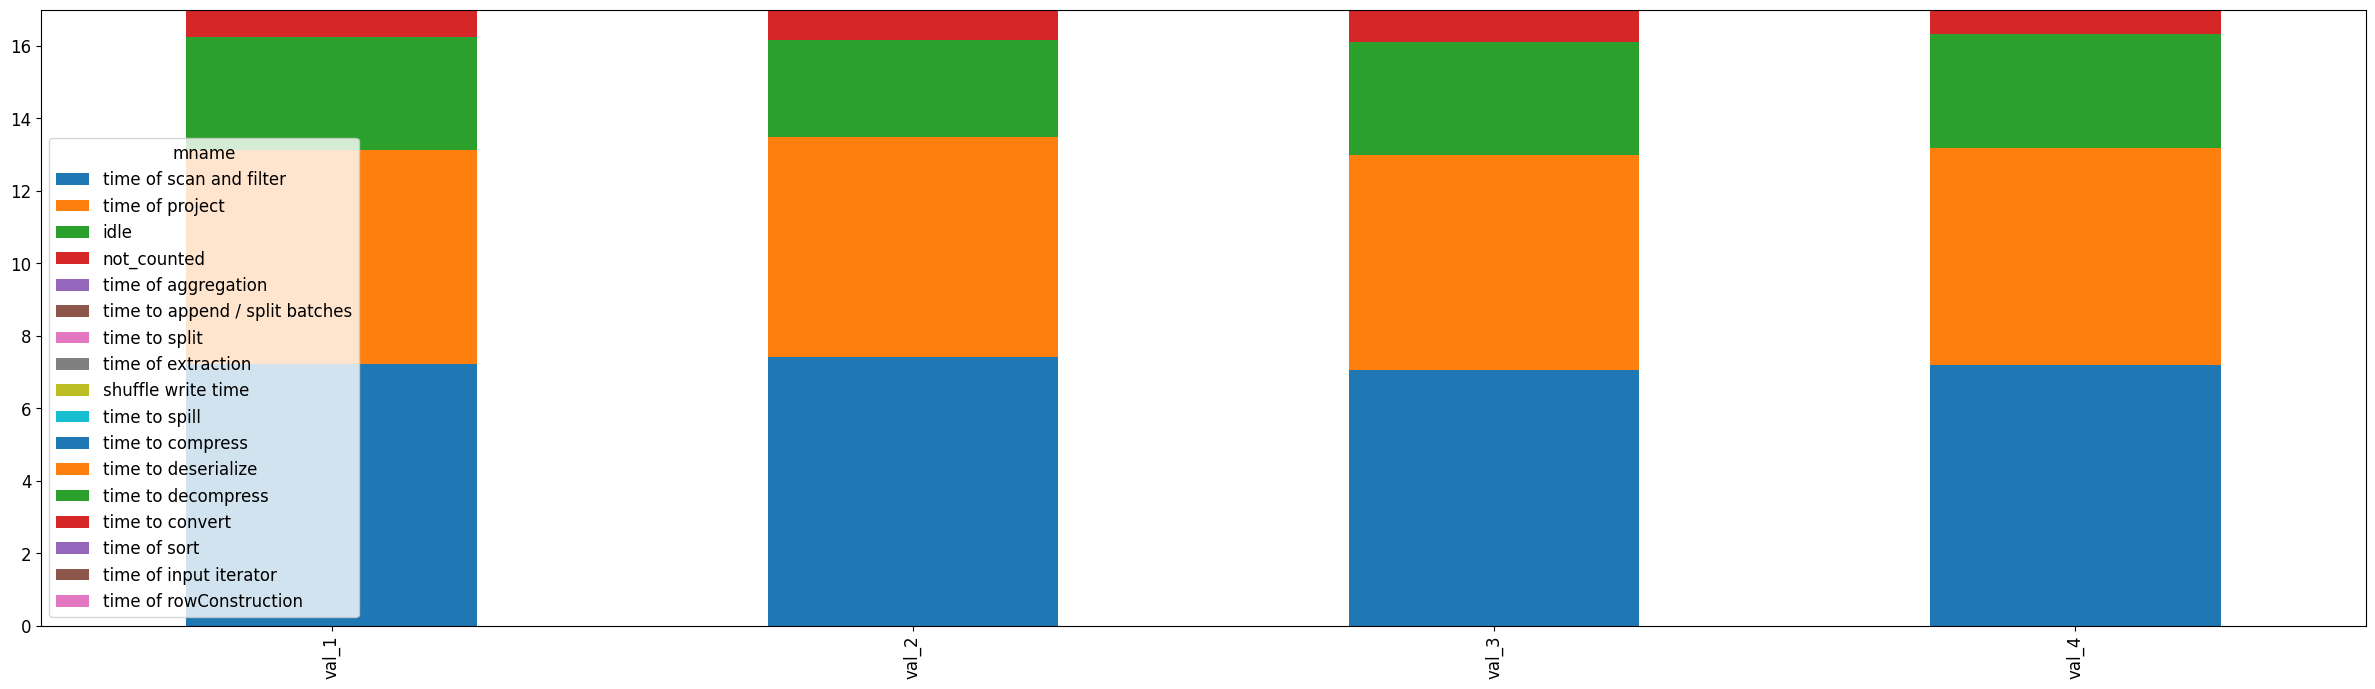

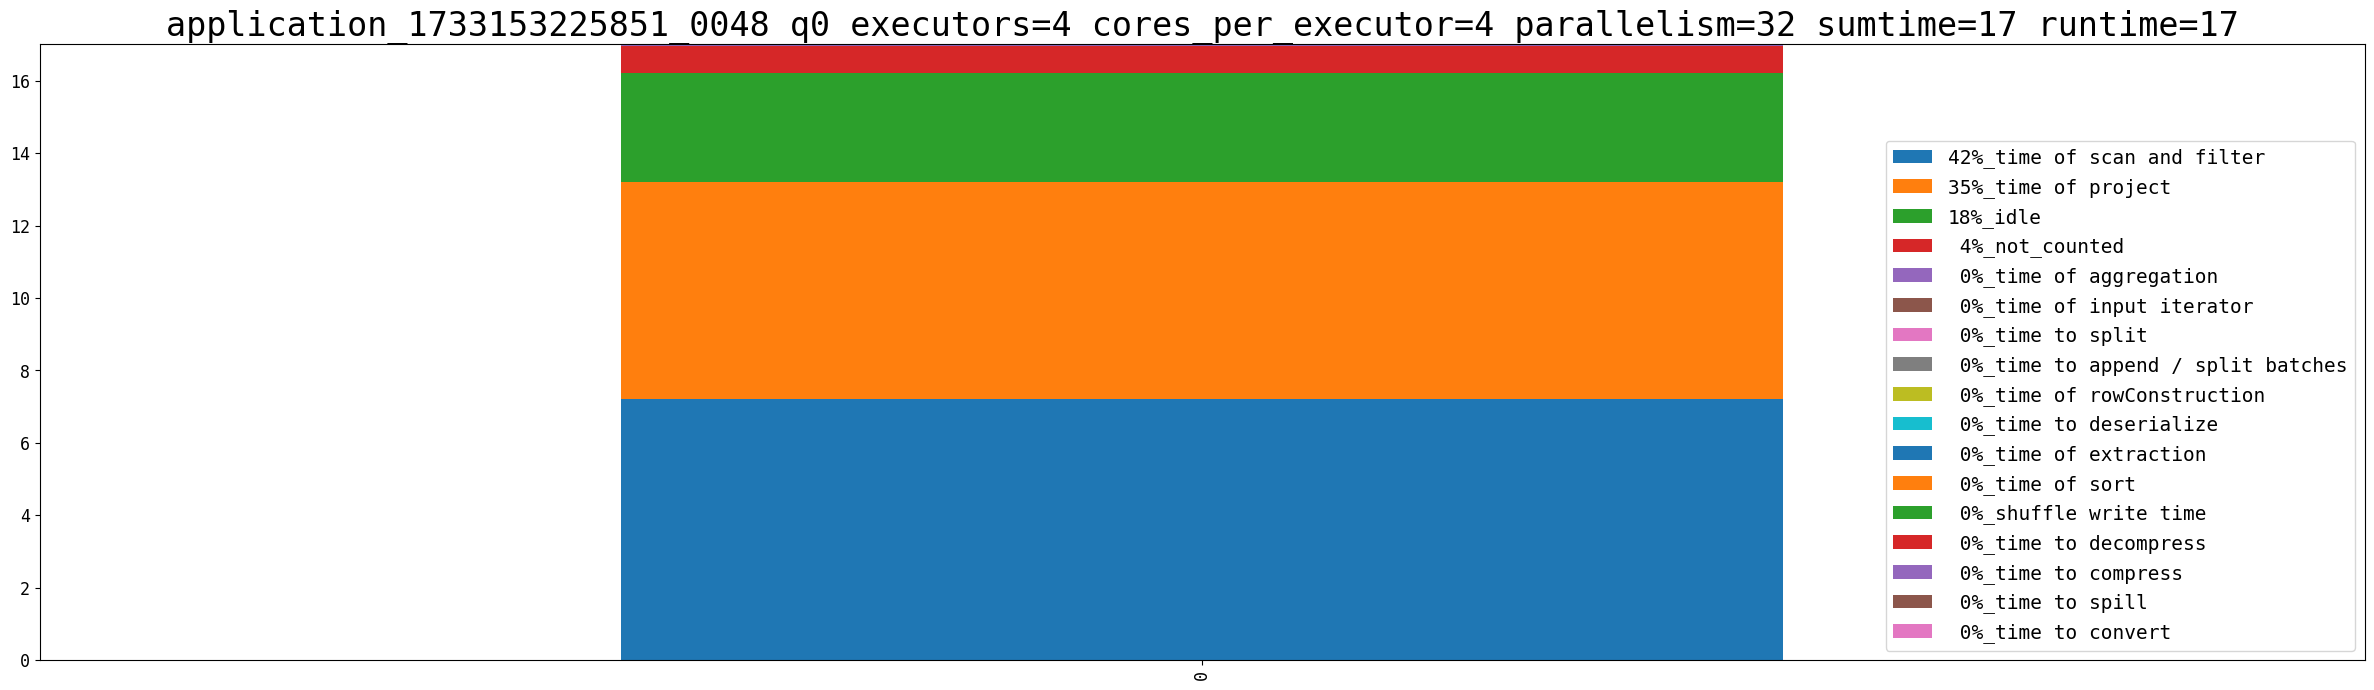

In [19]:
appals.get_app_info(disk_prefix=disk_prefix,nic_prefix=nic_prefix)

,0
44%_time of scan and filter,7.53
36%_time of project,6.13
16%_not_counted,2.69
3%_idle,0.55
0%_time of input iterator,0.06
0%_time of aggregation,0.03
0%_time to append / split batches,0.00
0%_time of rowConstruction,0.00
0%_time to split,0.00
0%_time to deserialize,0.00


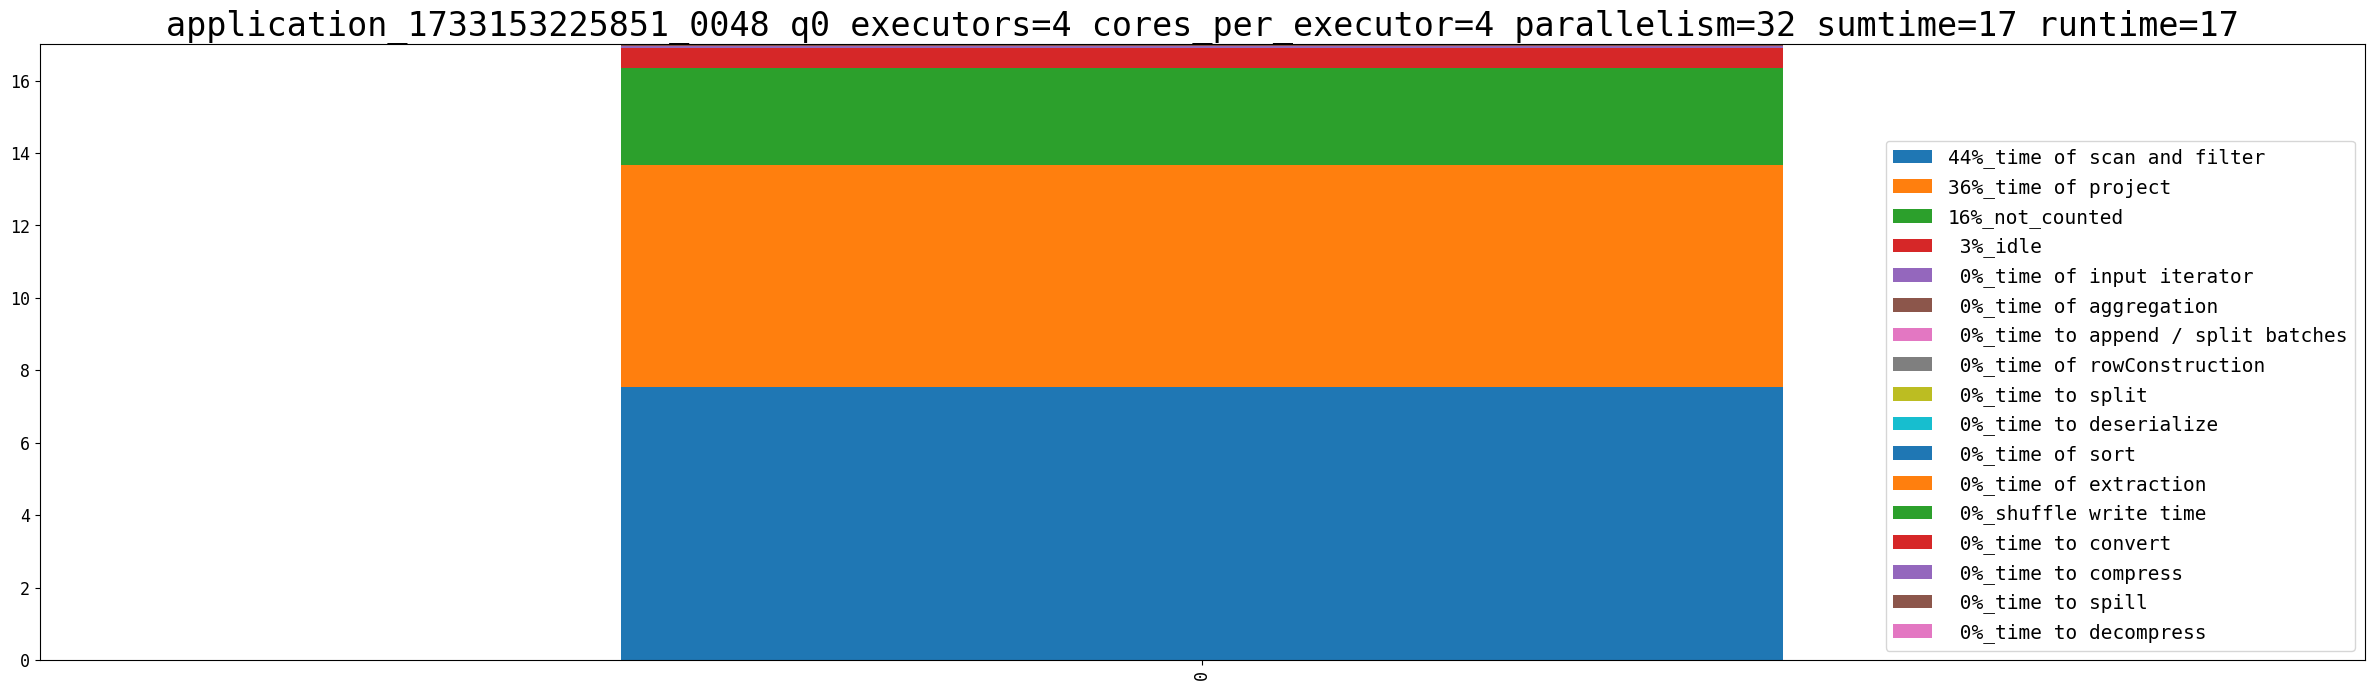

In [20]:
appals.show_critical_path_time_breakdown().T

# Compare to vanilla

load data  /sr213/application_1733153225851_0029/app.log


emon metric


sar metric


time breakdown


,application_1733153225851_0029,application_1733153225851_0048,diff
runtime,132.14,17.65,648.67%
shuffle_write,0.00,0.00,0.00%
f_wait_time,0.00,0.00,0.00%
input read,22.54,22.54,0.00%
acc_task_time,128.01,13.99,815.01%
output rows,1.79,1.18,51.69%
%user>90%,0.99,0.93,5.91%
%kernel>10%,0.99,0.97,2.85%
%iowait>10%,0.31,0.62,-49.30%
avg %user,82.11,41.22,99.21%


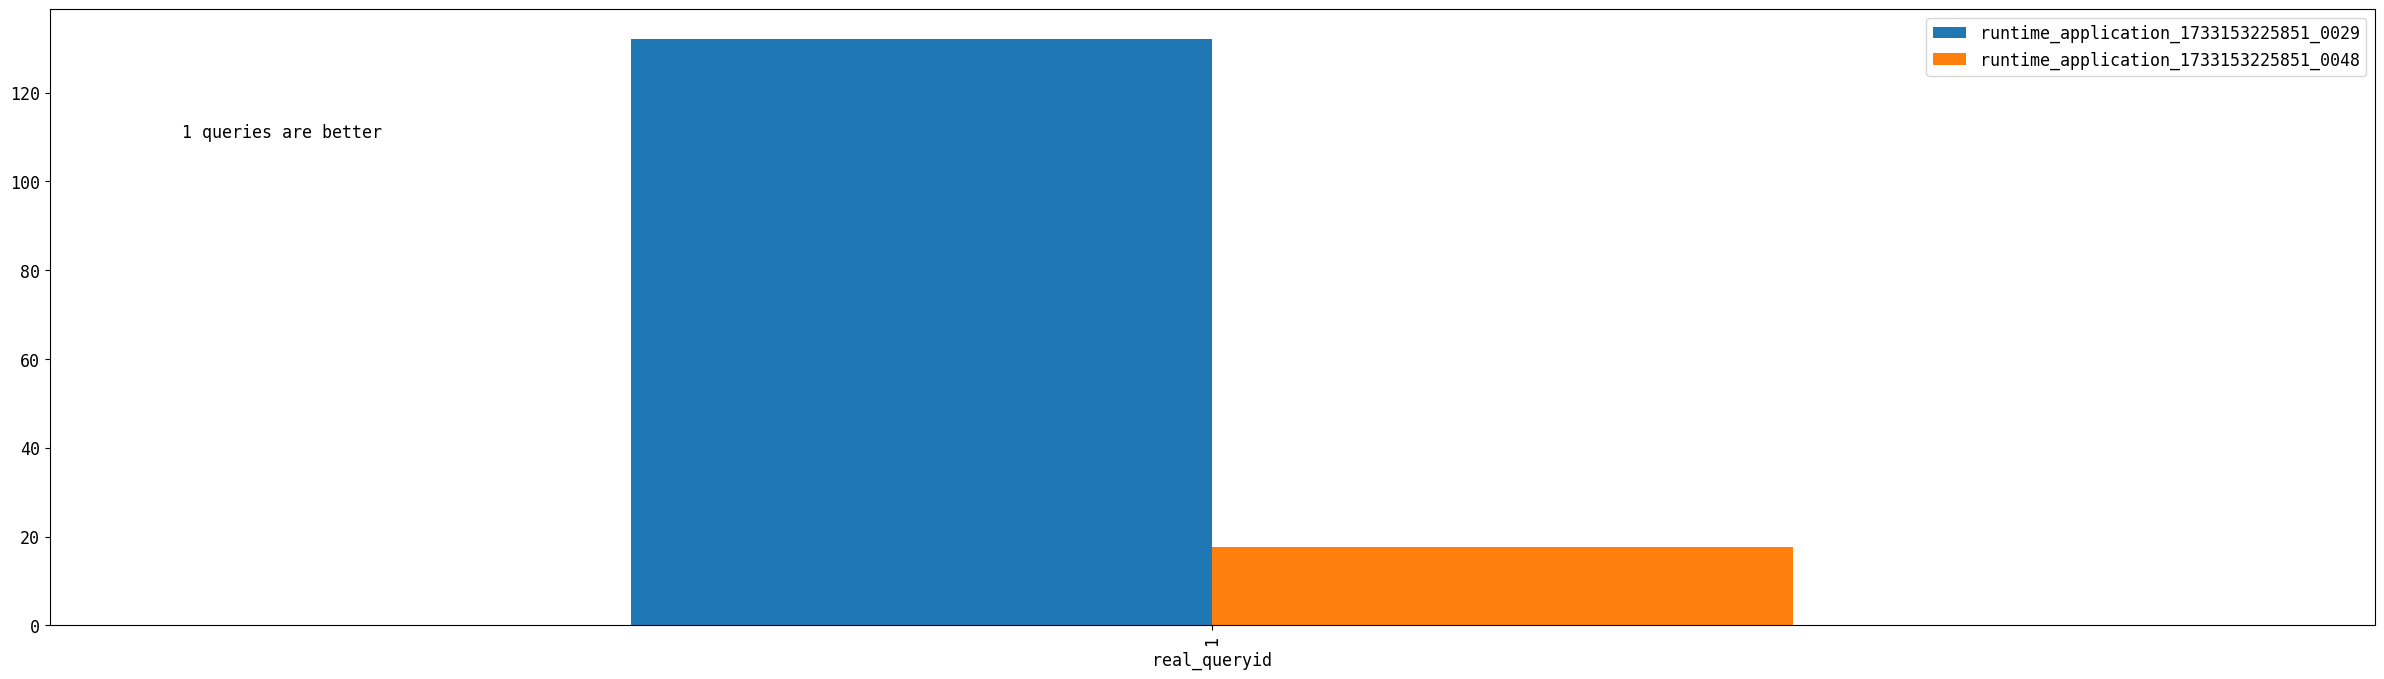

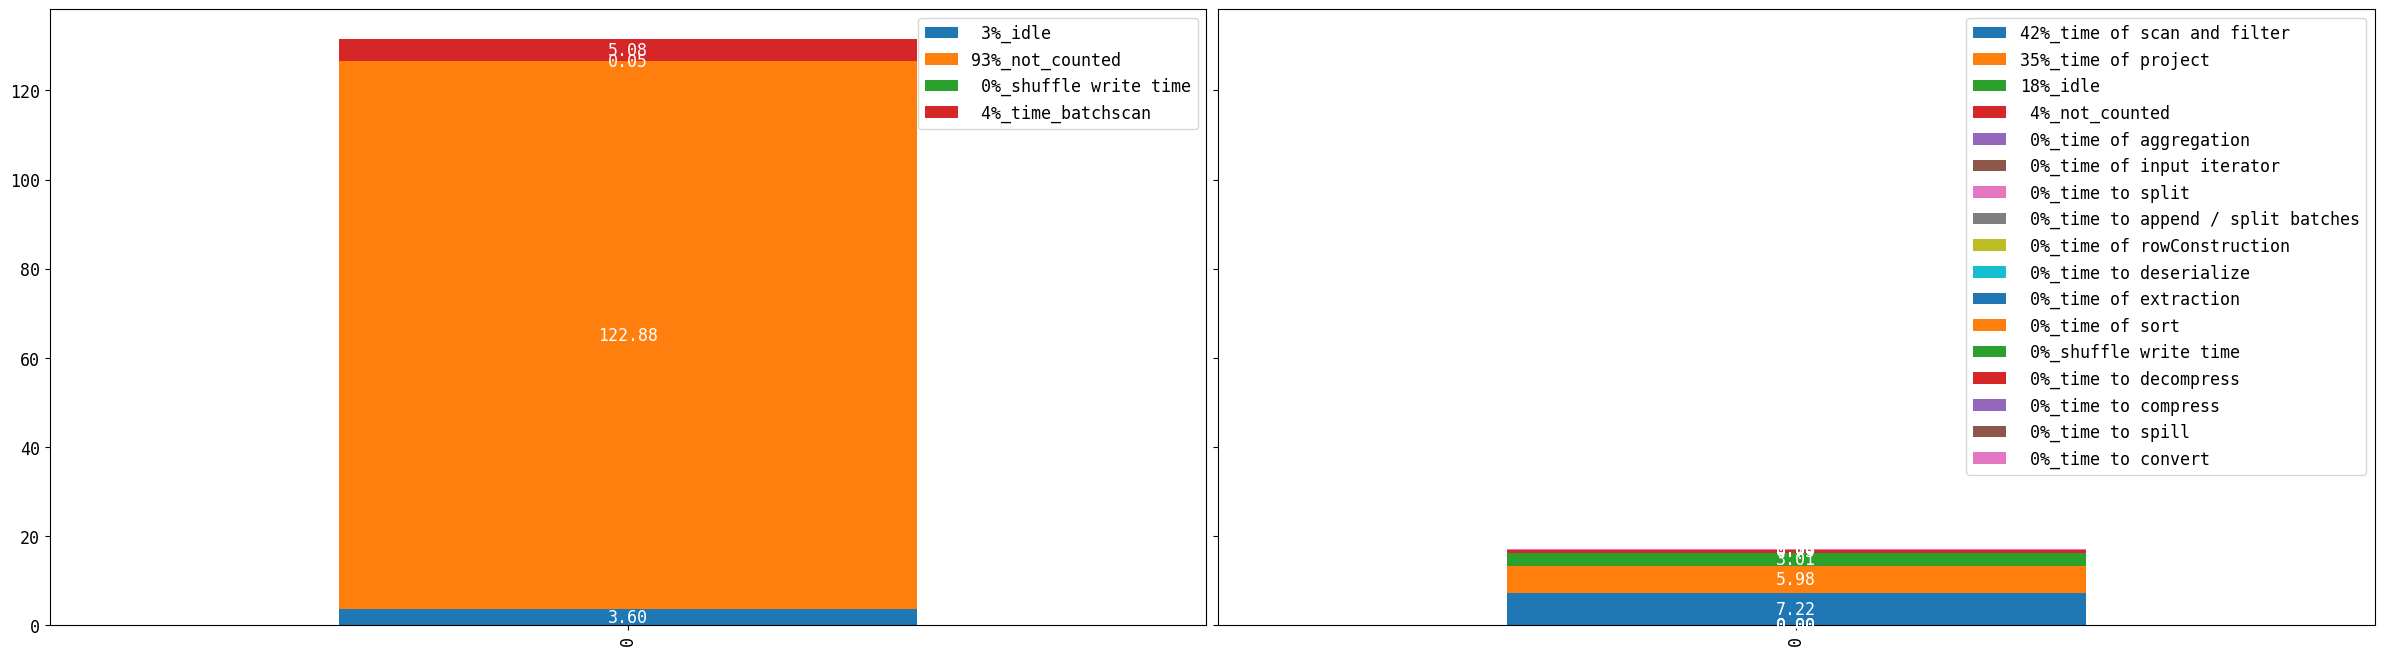

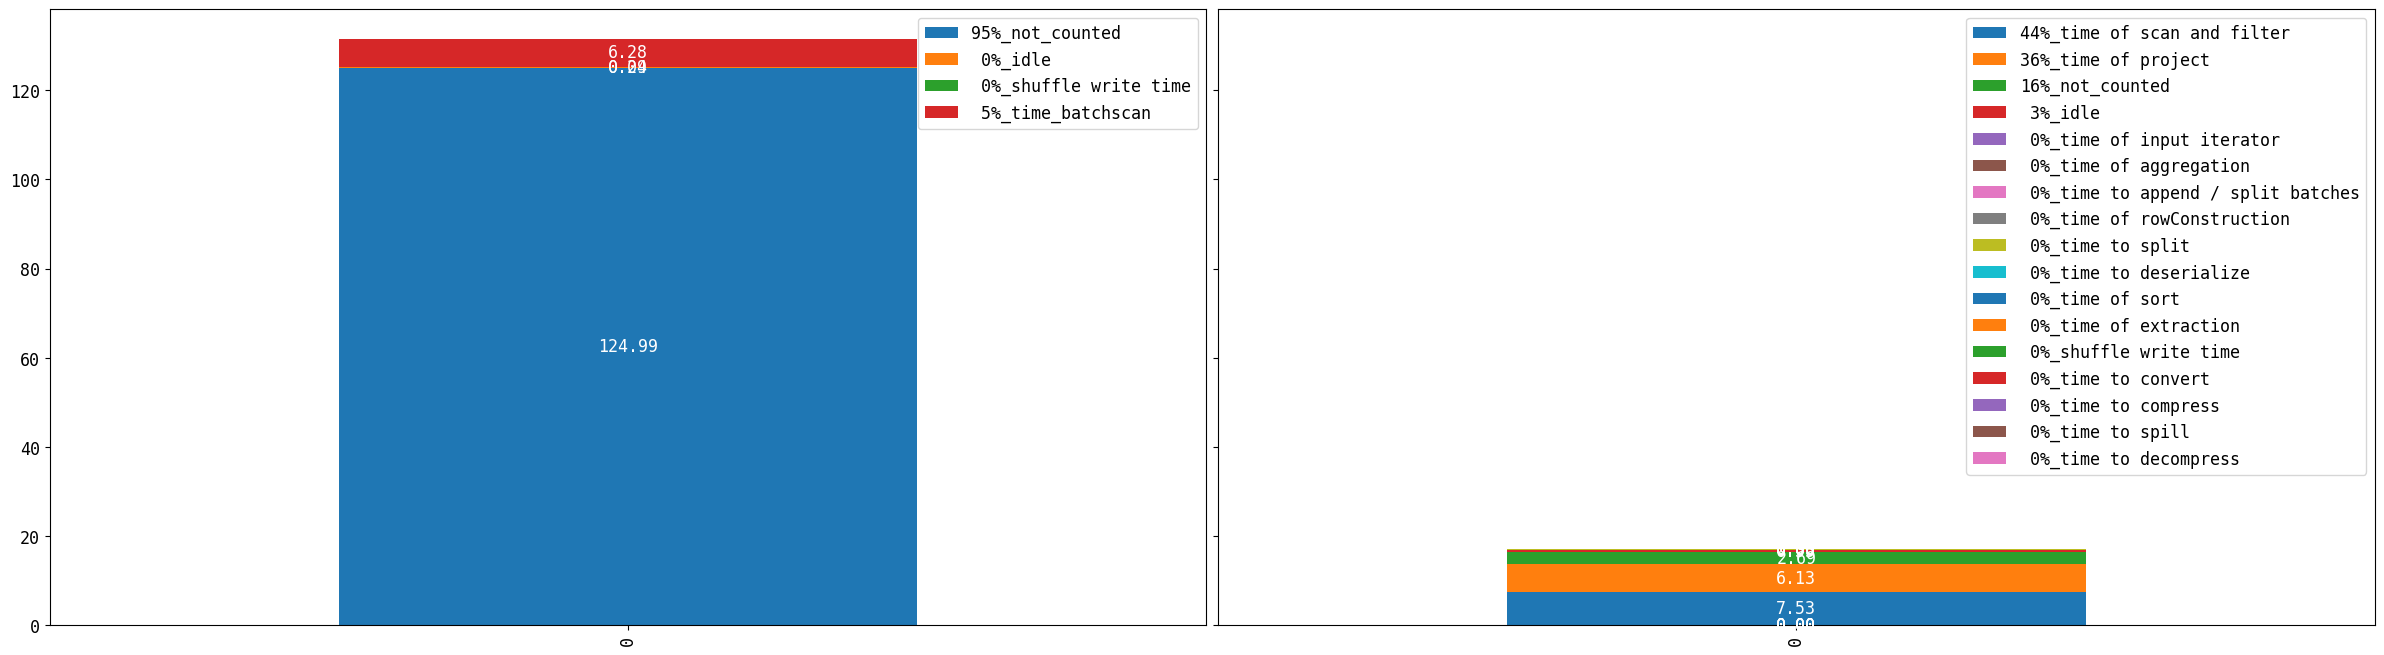

In [21]:
if comp_appid:
    comp_app=Application_Run(comp_appid,basedir=comp_base_dir)
    output=app.compare_app(rapp=comp_app,show_metric=emonmetric,show_queryplan_diff=False,disk_prefix=disk_prefix,nic_prefix=nic_prefix)
    display(HTML(output))

# Config compare

In [22]:
if comp_appid:
    comp_appals=comp_app.analysis['app']['als']
    display(comp_spark_conf(appals, comp_appals))

,0851_0048,0851_0029,comp
callSite.short,collect at /tmp/ipykernel_265482/1936321720.py:117,collect at /tmp/ipykernel_234307/1936321720.py:117,False
spark.app.submitTime,1733464301669,1733457038427,False
spark.executor.extraClassPath,file:///data0/home/sparkuser/jars/6600a164407ae0e4f5ea5b33dc4b902f23a27730/gluten-velox-bundle-spark3.3_2.12-centos_7_x86_64-1.5.0-snapshot.jar,,False
spark.executor.extraJavaOptions,-xx:+ignoreunrecognizedvmoptions --add-opens=java.base/java.lang=all-unnamed --add-opens=java.base/java.lang.invoke=all-unnamed --add-opens=java.base/java.lang.reflect=all-unnamed --add-opens=java.base/java.io=all-unnamed --add-opens=java.base/java.net=all-unnamed --add-opens=java.base/java.nio=all-unnamed --add-opens=java.base/java.util=all-unnamed --add-opens=java.base/java.util.concurrent=all-unnamed --add-opens=java.base/java.util.concurrent.atomic=all-unnamed --add-opens=java.base/sun.nio.ch=all-unnamed --add-opens=java.base/sun.nio.cs=all-unnamed --add-opens=java.base/sun.security.action=all-unnamed --add-opens=java.base/sun.util.calendar=all-unnamed --add-opens=java.security.jgss/sun.security.krb5=all-unnamed -xx:+useparalleloldgc -xx:parallelgcthreads=2 -xx:newratio=1 -xx:survivorratio=1 -xx:+usecompressedoops -verbose:gc -xx:+printgcdetails -xx:+printgctimestamps -xx:errorfile=/home/sparkuser/logs/java/hs_err_pid%p.log,-xx:+ignoreunrecognizedvmoptions --add-opens=java.base/java.lang=all-unnamed --add-opens=java.base/java.lang.invoke=all-unnamed --add-opens=java.base/java.lang.reflect=all-unnamed --add-opens=java.base/java.io=all-unnamed --add-opens=java.base/java.net=all-unnamed --add-opens=java.base/java.nio=all-unnamed --add-opens=java.base/java.util=all-unnamed --add-opens=java.base/java.util.concurrent=all-unnamed --add-opens=java.base/java.util.concurrent.atomic=all-unnamed --add-opens=java.base/sun.nio.ch=all-unnamed --add-opens=java.base/sun.nio.cs=all-unnamed --add-opens=java.base/sun.security.action=all-unnamed --add-opens=java.base/sun.util.calendar=all-unnamed --add-opens=java.security.jgss/sun.security.krb5=all-unnamed -xx:+useparalleloldgc -xx:parallelgcthreads=2 -xx:newratio=1 -xx:survivorratio=1 -xx:+usecompressedoops -verbose:gc -xx:+printgcdetails -xx:+printgctimestamps -xx:errorfile=/data0/home/sparkuser/logs/java/hs_err_pid%p.log,False
spark.executor.memory,10944m,29184m,False
spark.gluten.memory.conservative.task.offHeap.size.in.bytes,10041163776,NaN,False
spark.gluten.memory.dynamic.offHeap.sizing.enabled,false,NaN,False
spark.gluten.memory.offHeap.size.in.bytes,80329310208,NaN,False
spark.gluten.memory.overAcquiredMemoryRatio,0,NaN,False
spark.gluten.memory.task.offHeap.size.in.bytes,20082327552,NaN,False


#  Convert to HTML

In [23]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [24]:
# htmlname=nb_name.replace("ipynb","html")

In [25]:
# !jupyter nbconvert --to html ./{nb_name} --no-input --output html/{htmlname} --template classic